# Домашняя работа к уроку 5. Задача оттока: варианты постановки, возможные способы решения

#### Домашнее задание

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

5. (опционально) Еще раз провести оценку экономической эффективности


**Ссылки**

http://hyperopt.github.io/hyperopt/

https://arxiv.org/pdf/1907.03947.pdf

https://arxiv.org/pdf/1802.02301.pdf

https://arxiv.org/list/stat.ML/recent

https://scikit-learn.org/stable/modules/grid_search.html

https://scikit-learn.org/stable/modules/compose.html

#### 1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 
- 1 - бустинг, 
- 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

import itertools
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [5]:
# Построим модель. Сразу работаем с использованием sklearn pipeline
#разделим на train и test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [6]:
# Категориальные признаки закодируем с помощью OneHotEncoding
# Вещественные пока оставим как есть
#соберем pipeline, но нам понадобится написать класс для выбора нужного поля


class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]


class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]


class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [7]:
# Зададим списки признаков
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']  # категориальные признаки
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']  # непрерывные признаки

In [8]:
# Посмотрим как это работает на примере отдельного категориального признака - Gender
gender = Pipeline([('selector', FeatureSelector(column='Gender')),
                   ('ohe', OHEEncoder(key='Gender'))])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


In [9]:
# Ананлогичный пример для вещественного признака (+ применяем один из методов нормальзации)
tenure = Pipeline([('selector', NumberSelector(key='Tenure')),
                   ('standard', StandardScaler())])
tenure.fit(X_train)
tenure.transform(X_test)[:4]

array([[ 1.04718513],
       [-1.02946438],
       [ 1.04718513],
       [-0.33724788]])

In [10]:
# Теперь нам нужно под каждый признак создать трансформер и объединить их в список 
# (сделаем это в цикле, чтобы не мучиться)
final_transformers = list()

for categ_column in categorical_columns:
    cat_transformer = Pipeline([('selector', FeatureSelector(column=categ_column)),
                                ('ohe', OHEEncoder(key=categ_column))])
    final_transformers.append((categ_column, cat_transformer))

for continuous_column in continuous_columns:
    cont_transformer = Pipeline([('selector', NumberSelector(key=continuous_column)),
                                 ('standard', StandardScaler())])
    final_transformers.append((continuous_column, cont_transformer))

In [11]:
# Объединим все это в единый пайплайн
feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

# Теперь у нас есть пайплайн, который готовит признаки для моделирования

In [12]:
# Добавим модель
pipeline = Pipeline([('features', feats),
                     ('random_forest_classifier',
                      RandomForestClassifier(random_state=3))])
pipeline.fit(X_train, y_train)
pipeline.predict_proba(X_test)[:, 1]

array([0.35, 0.2 , 0.27, ..., 0.47, 0.24, 0.06])

In [13]:
# Для всех метрик напишем функцию
def scores(model):
    from sklearn.metrics import roc_auc_score, precision_recall_curve

    pipeline = Pipeline([('features', feats), ('model', model)])
    pipeline.fit(X_train, y_train)

    preds = pipeline.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, preds)

    fscore = (2 * precision * recall) / (precision + recall)
    roc_auc = roc_auc_score(y_true=y_test, y_score=preds)
    ix = np.argmax(fscore)

    return [round(i, 3) for i in
            [thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc]]

#### 2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

In [14]:
%time

results = pd.DataFrame([
    scores(model=RandomForestClassifier(random_state=3)),
    scores(model=GradientBoostingClassifier(random_state=3)),
    scores(model=LogisticRegression(random_state=3))
], columns=['Best Threshold', 'F-Score', 'Precision', 'Recall', 'ROC AUC score'])

results['models'] = ['RandomForestClassifier', 'GradientBoosting', 'LogisticRegression']
results = results.set_index('models')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10 µs


In [15]:
results.sort_values(by='Recall', axis=0, ascending=False)

,Best Threshold,F-Score,Precision,Recall,ROC AUC score
models,,,,,
RandomForestClassifier,0.400,0.655,0.684,0.629,0.861
GradientBoosting,0.409,0.646,0.704,0.597,0.876
LogisticRegression,0.290,0.510,0.462,0.568,0.772


**Вывод:** Думаю, что наилучшая метрика для данного случая Recall, т.к. нужно определить максимум выходящих пользователей, следовательно лучшая модель - RandomForestClassifier.

#### 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 
(1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). 

(подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

In [28]:
pipeline = Pipeline([('features', feats),
                     ('random_forest_classifier',
                      RandomForestClassifier(random_state=3))])
pipeline.fit(X_train, y_train)

y_score = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

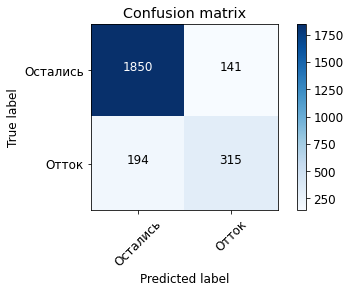

In [30]:
font = {'size' : 12}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['Остались', 'Отток'],
                      title='Confusion matrix');

In [31]:
costs = sum(cnf_matrix[:, 1]) * 1  # Траты
income = cnf_matrix[1, 1] * 2  # Возможный доход
print(f'Возможная прибыть с удержания = {income - costs}$')

Возможная прибыть с удержания = 174$


#### 4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

In [20]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier()),
])

In [21]:
from sklearn.model_selection import GridSearchCV

params={'classifier__n_estimators': [20, 50, 100],
        'classifier__max_depth': [2, 3, 4, 6]
       }

In [22]:
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=6,
                    scoring = 'average_precision')

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__max_depth': 3, 'classifier__n_estimators': 100}

In [23]:
%time

results = pd.DataFrame([
    scores(model=RandomForestClassifier(n_estimators = 100)),
    scores(model=GradientBoostingClassifier()),
    scores(model=LogisticRegression(solver = 'lbfgs')),
    scores(model=GradientBoostingClassifier(max_depth=3, n_estimators=100))
], columns=['Best Threshold', 'F-Score', 'Precision', 'Recall', 'ROC AUC score'])

results['models'] = ['RandomForestClassifier', 'GradientBoosting', 'LogisticRegression', 'GradientBoosting_t']
results = results.set_index('models')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [24]:
results.sort_values(by='Precision', axis=0, ascending=False)

,Best Threshold,F-Score,Precision,Recall,ROC AUC score
models,,,,,
GradientBoosting,0.409,0.646,0.704,0.597,0.876
GradientBoosting_t,0.409,0.646,0.704,0.597,0.876
RandomForestClassifier,0.380,0.655,0.667,0.642,0.863
LogisticRegression,0.290,0.510,0.462,0.568,0.772


**Вывод:** Экономическая эффективность GradientBoosting_t не изменилась.

In [25]:
params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__min_samples_leaf': [1, 2, 3],
    'classifier__max_depth': [3, 4, 5]
}

In [26]:
grid = GridSearchCV(results,
                    param_grid=params,
                    cv=5,
                    refit=False)

In [34]:
search = grid.fit(X_train, y_train)
search.best_params_

TypeError: ignored

In [ ]:
optimal_model = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(n_estimators=100, max_depth=5, min_samples_leaf=3, random_state=42)),
])

In [ ]:
optimal_model.fit(X_train, y_train)

In [ ]:
y_pred_optim = optimal_model.predict_proba(X_test)[:, 1]

In [ ]:
def threshold_by_fbeta(y_test: pd.Series, y_pred: list, *, beta: int = 1) -> tuple:
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    fbeta = ((1 + beta**2) * precision * recall) / (beta**2 * precision + recall)
    index = np.argmax(fbeta)
    return thresholds[index], fbeta[index]

In [ ]:
threshold, fbeta_score = threshold_by_fbeta(y_test, y_pred_optim, beta=2)

In [ ]:
threshold, fbeta_score

#### 5. (опционально) Еще раз провести оценку экономической эффективности

In [ ]:
y_pred_best = optimal_model.predict_proba(X_test)[:, 1]
_, _, thresholds = precision_recall_curve(y_test, y_pred_optim)

In [ ]:
def economic_metrics(y_pred_probas: list, thresholds: list) -> pd.DataFrame:
    profits = []
    expenses = []
    for thr in thresholds:
        preds = (y_pred_best >= thr).astype(bool)
        conf = confusion_matrix(y_test, preds)
        TP = conf[1][1]
        FP = conf[0][1]
        profits.append(TP * 2)
        expenses.append(FP * -1)

    results_df = pd.DataFrame({'threshold': thresholds, 'profit': profits, 'expense': expenses})
    results_df['total'] = results_df['profit'] + results_df['expense']
    return results_df

In [ ]:
results = economic_metrics(y_pred_best, thresholds)

In [ ]:
_, _, thresholds_optim = precision_recall_curve(y_test, y_pred_optim)

In [ ]:
results_optim = economic_metrics(y_pred_best, thresholds_optim)

In [ ]:
results_optim.sort_values('total', ascending=False)

Одним из лучших значений является значение 0.404124 с прибылью 458 долларов.